# Discrete Population Compartmental Model

Treats the population as discrete rather than continuous.

In [1]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv
from scipy.optimize import curve_fit

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

towns = list(waloc['City / Town'])

In [5]:
d = {}
d['none']=pd.read_csv("/Volumes/HardDrive/New_Workflow/restrictions_44_<250/no_rest.csv", header = None, sep =',')
d['regional']=pd.read_csv("/Volumes/HardDrive/New_Workflow/restrictions_44_<250/regional_only.csv", header = None, sep =',')

In [6]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    
    return xdot, infected_daily

In [7]:
def change_assignment(daily_changes, popn, total_popn):
    # A 'quick and dirty' way of making sure the changes in each town are discrete
    # Assign changes based on population and then round, making sure that the overall sum is true (see rounding)
    town_changes = []
    for c in daily_changes:
        to = []
        for p in popn:
            to.append(c/total_popn*p)
        town_changes.append(rounding(to))
    #town_changes = rounding(town_changes)
        
    return town_changes

In [8]:
# This just double checks that the sveir equations actually sum to 0 for some random set of numbers

x = [i+1 for i in range(7)]
params = [7,11,12]
changes = [8,9,10]
popn = 30
eff1, eff2, eff3 = 0.6,0.4,0.8

sum([-params[0]*x[0]*x[5]/popn - changes[0], 
     -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1], 
     -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2], 
     -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6], 
     params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn, 
     eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4],
     params[1]*x[4] - params[2]*x[5], params[2]*x[5] - 1/84*x[6]])

0.0

In [9]:
def bernoulli(flow_list,x,pop,total_out,num):
    
    p1 = x[0]/pop 
    p2 = x[1]/pop
    p3 = x[2]/pop
    p4 = x[3]/pop
    p5 = x[4]/pop
    p6 = x[5]/pop
    p7 = x[6]/pop
    
    comp1 = 0
    comp2 = 0
    comp3 = 0
    comp4 = 0
    comp5 = 0
    comp6 = 0
    comp7 = 0

    vector = []
    
    while len(vector) < total_out:
        r1 = random.rand()
        if (r1 <= p1) & (comp1 < x[0]):
            vector.append(0)
            comp1 += 1
        elif (r1>p1) & (r1 <= (p1+p2)) & (comp2 < x[1]):
            vector.append(1)
            comp2 += 1
        elif (r1 > p1+p2) & (r1 <= p1+p2+p3)& (comp3 < x[2]):
            vector.append(2)
            comp3 += 1
        elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4) & (comp4 < x[3]):
            vector.append(3)
            comp4 += 1
        elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5) & (comp5 < x[4]):
            vector.append(4)
            comp5 += 1
        elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6) & (comp6 < x[5]):
            vector.append(5)
            comp6 += 1
        elif (r1 > p1+p2+p3+p4+p5+p6) & (comp7 < x[6]):
            vector.append(6)
            comp7 += 1
    #print(total_out, ps,pop)
    
    random.shuffle(vector)
    
    flow_list = rounding(flow_list)
    cum_flow = [0]
    for f in flow_list:
        cum_flow.append(f+cum_flow[-1])
    
    mo = []
    for j in range(1,num+1):
        vec = vector[cum_flow[j-1]:cum_flow[j]]

        occ = dict(collections.Counter(vec))
        for i in range(7):
            occ[i] = occ.get(i,0)
        mo.append(occ)

    return mo

In [27]:
def dynamics(x_init, num, steps, params, popn, daily_changes,factor):
    
    x = x_init
    y = []
    #changes = [0,0,0]
    
    town_changes = change_assignment(daily_changes,popn,total_popn)
    
    town_infs = []
    for i in range(num):
        
        changes = [town_changes[0][i], town_changes[1][i], town_changes[2][i]]
        
        spec_params = [params[0]/factor[i], params[1],params[2]]
        
        xy = []
        infected_daily = []
        for t in range(steps):
            if t == 0:
                xdot, infs = sveir(spec_params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
                infected_daily.append(infs)
            else:
                xdot, infs = sveir(spec_params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
                infected_daily.append(infs)
            #print(xy)
            
        town_infs.append(round(sum(infected_daily)/steps))
        y.append(rounding(xy[-1]))
    
    return y, town_infs

In [28]:
def rounding(numbers):
    # This function does what I call 'collective rounding'
    # I.e. it considers what the other numbers are so that the overall sum is maintained
    # E.g. [1.2,1.2,1.4,1.2] gets rounded to [1,1,2,1] (which sums to 5 rather than 4, as the original list was)
    
    summ = round(sum(numbers))
    int_summ = sum([round(i) for i in numbers])
    
    if summ > int_summ:
        diff = summ - int_summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(max(dec))
            numbers[ind] += 1
            dec[ind] = 0
    elif summ < int_summ:
        diff = int_summ - summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(min(dec))
            numbers[ind] -= 1
            dec[ind] = 0
    
    return [round(j) for j in numbers]

In [29]:
def movement(x_init, day, num_towns,popn, flow):
        
    
    #flow = round(d['lvl_2'].copy()*C/7)
    
    move = []
    for i in range(num_towns):
        temp_mo = []
        total_out = sum(list(flow[i]))
        pop = popn[i]
        mo = bernoulli(list(flow[i]),x_init[i],pop,total_out,num)
        move.append(mo)
        
    out = []   
    inc = []
    for i in range(num_towns):
        temp_out = []
        temp_inc = []
        for k in range(7):
            mini_out = []
            mini_inc = []
            for j in range(num_towns):
                mini_out.append(move[i][j][k])
                mini_inc.append(move[j][i][k])
            temp_out.append(sum(mini_out))
            temp_inc.append(sum(mini_inc))
        out.append(temp_out)
        inc.append(temp_inc)            

    return inc, out

In [30]:
## WA Data Processing
wa_data = pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv')

# Daily cases
wa_totals = list(wa_data.iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])
    
total_popn = sum(list(waloc['Population']))

# WA's population is 2491996 people over 5
# https://www.health.gov.au/sites/default/files/documents/2022/02/covid-19-vaccine-rollout-update-1-february-2022.pdf
# There are 377018 people between 5-15, so normalise the third dose based on that

first = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1:]
first = [round(i/2491996*total_popn) for i in first]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1:]
second = [round(i/2491996*total_popn) for i in second]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1:]
third = [round(i*2491996/(2491996-377018)) for i in third]
third = [round(i/2491996*total_popn) for i in third]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]

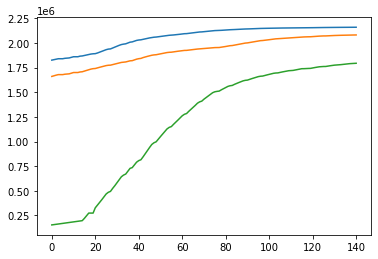

In [31]:
plt.plot(first)
plt.plot(second)
plt.plot(third)

In [33]:
# Make sure no negatives
for i in range(len(uptakes)):
    for j in range(len(uptakes[i])):
        if uptakes[i][j] < 0:
            print(i,j)
            uptakes[i][j] = 0

In [34]:
# Find initial values

init_first_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1]
init_first_dose = init_first_dose/2491996
init_second_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1]
init_second_dose = init_second_dose/2491996
init_third_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1]
init_third_dose = init_third_dose*2491996/(2491996-377018)
init_third_dose = init_third_dose/2491996

init1 = init_first_dose- init_second_dose
init2 = init_second_dose - init_third_dose
init3 = init_third_dose

In [35]:
popn = list(waloc['Population'])

num = 44
one = 1/popn[0]
#x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
x_init = [1-init1 - init2 - init3 - 5*one, init1 - 5*one, init2 - 5*one, init3 - 5*one, 16*one, 4*one,0]

# Go with 0 infections elsewhere
y_init = [1-init1 - init2 - init3, init1, init2, init3, 0, 0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(round(item[j] * popn [i]))
    town_init.append(new_item)  
    
    
days = 180
steps = 5


#a1, a2,a3, L, D =4.26855088, 4.50297884, 6.        , 0.5       , 0.80237211
inflection_points = [16, 44, 80, 1000]

L = 2.43
D = 3.778


# Setting parameters
a1 = (0.435+0.449)/2
a2 = (0.448+0.462)/2
a3 = (0.897+0.912)/2
a4 = (0.560+0.573)/2
a5 = 1
#a1, a2,a3,a4,a5 =0.449,0.462,0.912,0.573,1
#a1, a2,a3,a4 =0.45608311, 0.41987906, 0.88259268, 0.53438241

#a1,a2,a3,a4 = 0.42498438, 0.92310499, 0.65079971, 0.48884082
#a1,a2,a3,a4 = 0.42489662, 0.95409028, 0.72054499, 0.531649

#a1,a2,a3,a4 = 1.54996772, 1.54998557, 1.54998902, 1.55003052
#a1,a2,a3,a4 = 0.432, 0.932, 0.668, 0.504
#a1,a2,a3,a4 = 0.42624263, 0.93523871, 0.72312885, 0.54006024

effic = [1-0.293, 1-0.126, 1-0.566]

C= 9*10**9

params = [a1, 1/L, 1/D]

In [36]:
ratio = list(pd.read_csv('/Volumes/HardDrive/New_Workflow/44_self_loop_ratio/ratio_44.csv', header = None).iloc[0])

In [37]:
def run_the_sim(days, params, a1, a2, a3, a4, uptakes, num, steps, popn, model, day_infs, flow, inflection_points,factor):
    
    inf_1, inf_2, inf_3, inf_4 = inflection_points[0],inflection_points[1],inflection_points[2],inflection_points[3]
    
    for day in range(days):
        #print(day)

        if day < inf_1:
            params[0] = a1
        elif (day>= inf_1) and (day < inf_2):
            params[0] = a2
        elif (day >=inf_2) and (day<inf_3):
            params[0] = a3
        elif (day>=inf_3) and (day<inf_4):
            params[0] = a4
        elif day>inf_4:
            params[0] = a5
        
        if day < 140:
            daily_changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        else:
            daily_changes = [0,0,0]

        dyn, town_infs = dynamics(model[-1], num, steps, params, popn, daily_changes, factor)

        day_infs.append(sum(town_infs) + day_infs[-1])

        inc, out = movement(dyn, day, num, popn, flow)

        dynmov = []
        for i in range(num):
             dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

        model.append(dynmov)
    print('Done')

    return model, day_infs

In [39]:
num_iter = 10

# Free movement

In [49]:
start = time.time()
#model = [town_init]
#x_init = town_init
#day_infs = [0]

flow = round(d['none'].copy()*C/7)
factor = [1]*44

# The parallelisation:
# Choose n_jobs = -1 if want all processors, otherwise decide how many. range(x) is how many simulations you wanna do
results = Parallel(n_jobs=-1)(delayed(run_the_sim)(days, params, a1, a2, a3,a4, uptakes, num, steps, popn, [town_init], [0], flow, inflection_points, factor) for _ in range(num_iter))
   
end = time.time()
print(end-start)

allsims = []
allsims_infs = []
for item in results:
    allsims.append(item[0])
    allsims_infs.append(item[1])

71.75535988807678


In [50]:
cum_breaks = []
for model in allsims:
    breaks = []
    for k in range(num):
        town_cases = []
        for day in range(days):
            town_cases.append(model[day][k][5])
        zeroes = np.nonzero(town_cases)[0]
        if len(zeroes) > 0:
            breaks.append(zeroes[0])
        else:
            breaks.append('NA')

    cum_breaks.append(breaks)

In [51]:
with open("/Volumes/HardDrive/New_Workflow/breaks_44_<250/free_movement.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cum_breaks)

# Regional Restrictions

In [43]:
start = time.time()
#model = [town_init]
#x_init = town_init
#day_infs = [0]

flow = round(d['regional'].copy()*C/7)
factor = [1]*44

# The parallelisation:
# Choose n_jobs = -1 if want all processors, otherwise decide how many. range(x) is how many simulations you wanna do
results = Parallel(n_jobs=-1)(delayed(run_the_sim)(days, params, a1, a2, a3,a4, uptakes, num, steps, popn, [town_init], [0], flow, inflection_points, factor) for _ in range(num_iter))
   
end = time.time()
print(end-start)

allsims = []
allsims_infs = []
for item in results:
    allsims.append(item[0])
    allsims_infs.append(item[1])

34.57551693916321


In [44]:
cum_breaks = []
for model in allsims:
    breaks = []
    for k in range(num):
        town_cases = []
        for day in range(days):
            town_cases.append(model[day][k][5])
        zeroes = np.nonzero(town_cases)[0]
        if len(zeroes) > 0:
            breaks.append(zeroes[0])
        else:
            breaks.append('NA')

    cum_breaks.append(breaks)

In [45]:
with open("/Volumes/HardDrive/New_Workflow/breaks_44_<250/regional_restrictions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cum_breaks)

# Full Lockdown

In [46]:
start = time.time()
#model = [town_init]
#x_init = town_init
#day_infs = [0]

flow = round(d['regional'].copy()*C/7)
factor = ratio

# The parallelisation:
# Choose n_jobs = -1 if want all processors, otherwise decide how many. range(x) is how many simulations you wanna do
results = Parallel(n_jobs=-1)(delayed(run_the_sim)(days, params, a1, a2, a3,a4, uptakes, num, steps, popn, [town_init], [0], flow, inflection_points, factor) for _ in range(num_iter))
   
end = time.time()
print(end-start)

allsims = []
allsims_infs = []
for item in results:
    allsims.append(item[0])
    allsims_infs.append(item[1])

30.99530291557312


In [47]:
cum_breaks = []
for model in allsims:
    breaks = []
    for k in range(num):
        town_cases = []
        for day in range(days):
            town_cases.append(model[day][k][5])
        zeroes = np.nonzero(town_cases)[0]
        if len(zeroes) > 0:
            breaks.append(zeroes[0])
        else:
            breaks.append('NA')

    cum_breaks.append(breaks)

In [48]:
with open("/Volumes/HardDrive/New_Workflow/breaks_44_<250/full_lockdown.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cum_breaks)

# Scrap Code

In [47]:
# WITHOUT PARALLELISATION

allsims = []
allsims_infs = []

flow = round(d['lvl_2'].copy()*C/7)

start = time.time()
for it in range(num_iter):
    #model = [town_init]

    #x_init = town_init

    #day_infs = [0]

    model, day_infs = run_the_sim(days, params, a1, a2, a3, a4, uptakes, num, steps, popn, [town_init], [0], flow, inflection_points)
    
    allsims.append(model)
    allsims_infs.append(day_infs)

end = time.time()    
print(end-start)

Done
Done
Done
Done
Done
60.680591106414795


In [56]:
dic_break = {}
for i in range(len(cum_breaks[0])):
    dic_break[towns[i]] = cum_breaks[0][i]

dic_break

{'Perth': 0,
 'Bunbury': 58,
 'Geraldton': 70,
 'Kalgoorlie-Boulder': 43,
 'Albany': 73,
 'Busselton': 50,
 'Karratha': 19,
 'Broome': 55,
 'Port Hedland': 46,
 'Esperance': 91,
 'Collie': 57,
 'Northam': 45,
 'Margaret River': 72,
 'Dunsborough': 63,
 'Newman': 36,
 'Carnarvon': 110,
 'Narrogin': 112,
 'Manjimup': 66,
 'Katanning': 73,
 'Tom Price': 45,
 'Port Denison-Dongara': 41,
 'Harvey': 62,
 'Merredin': 63,
 'Denmark': 84,
 'York': 57,
 'Donnybrook': 59,
 'Exmouth': 132,
 'Waroona': 73,
 'Capel': 62,
 'Mount Barker': 90,
 'Kambalda West': 33,
 'Little Grove': 89,
 'Moora': 60,
 'Wickham': 29,
 'Cowaramup': 63,
 'Halls Creek': 'NA',
 'Jurien Bay': 74,
 'Paraburdoo': 34,
 'Wagin': 'NA',
 'Kalbarri': 98,
 'Kojonup': 82,
 'Fitzroy Crossing': 'NA',
 'Augusta': 75,
 'Mandurah': 1}

In [57]:
#with open("/Volumes/HardDrive/New_Workflow/breaks_44_<250/lvl_2.csv", "w", newline="") as f:
#    writer = csv.writer(f)
#    writer.writerows(cum_breaks)

In [58]:
#allDone()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Text(0.5, 0, 'Days from outbreak')

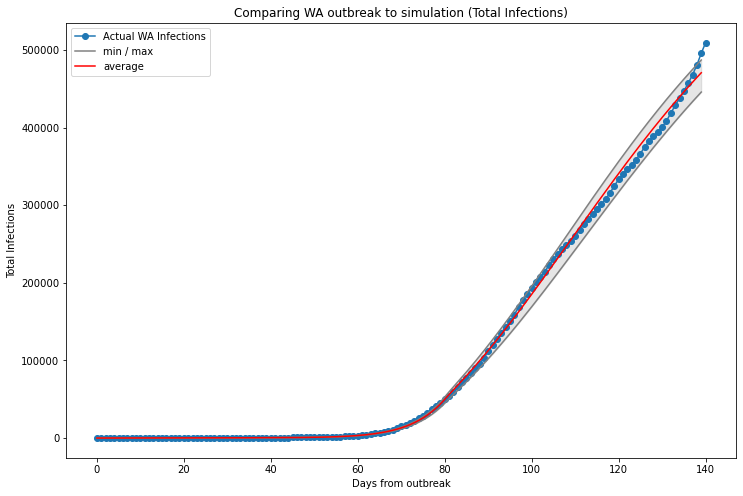

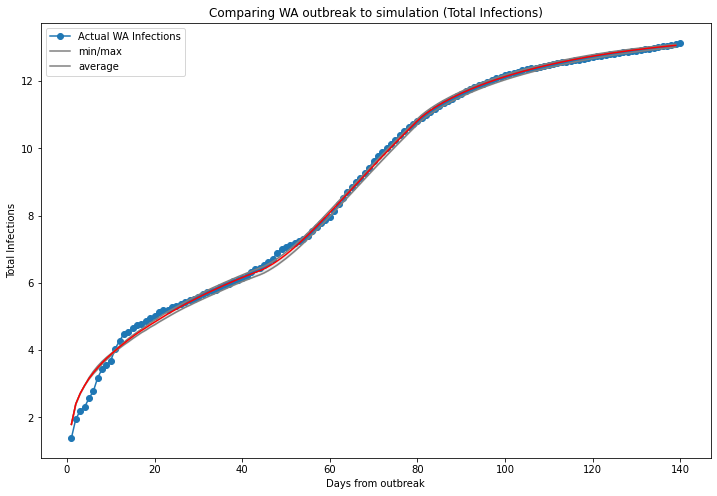

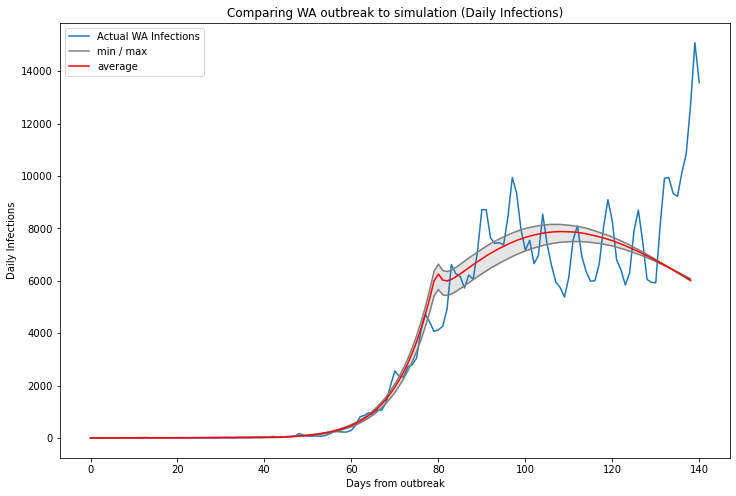

In [59]:
zp = list((zip(*allsims_infs)))

minn = []
maxx = []
avg = []
for i in range(days):
    minn.append(min(zp[i]))
    maxx.append(max(zp[i]))
    avg.append(np.mean(zp[i]))
    
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, marker = 'o',label = 'Actual WA Infections')
plt.fill_between([i for i in range(days)], minn, maxx, color='grey', alpha=.2)
plt.plot(minn, color = 'grey')
plt.plot(maxx, color = 'grey', label = 'min / max')
plt.plot(avg,color = 'red', label = 'average')
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')
plt.legend()

plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(np.log(wa_totals), marker = 'o',label = 'Actual WA Infections')
plt.fill_between([i for i in range(days)], np.log(minn), np.log(maxx), color='grey', alpha=.2)
plt.plot(np.log(minn), color = 'grey', label = 'min/max')
plt.plot(np.log(maxx), color = 'grey', label = 'average')
plt.plot(np.log(avg),color = 'red')
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')
plt.legend()

plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
for i in range(num_iter):
    day_maxx = [maxx[i]-maxx[i-1] for i in range(1,len(maxx))]
    day_minn = [minn[i]-minn[i-1] for i in range(1,len(minn))]
    day_avg = [avg[i]-avg[i-1] for i in range(1,len(maxx))]
plt.plot(day_minn, color = 'grey')
plt.plot(day_maxx, color = 'grey', label = 'min / max')
plt.fill_between([i for i in range(days-1)], day_minn, day_maxx, color='grey', alpha=.2)
plt.plot(day_avg,color = 'red', label = 'average')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Text(0.5, 0, 'Days from outbreak')

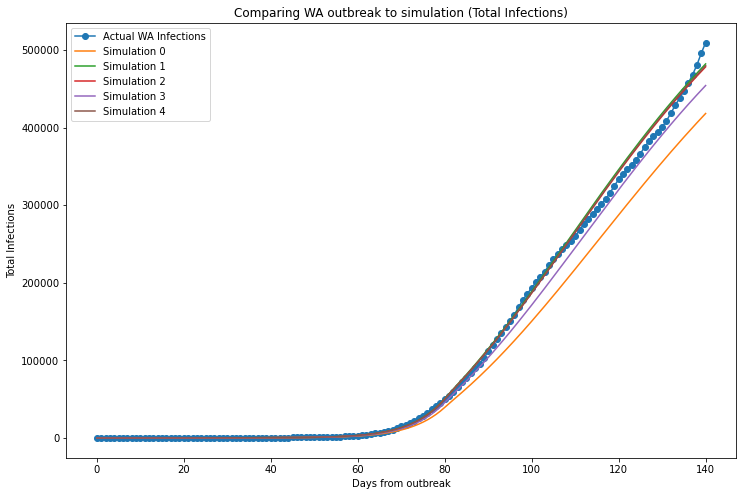

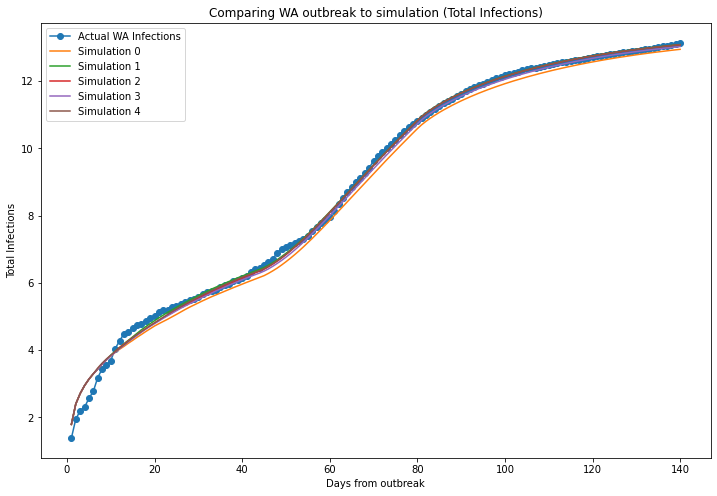

In [53]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, marker = 'o',label = 'Actual WA Infections')
for i in range(num_iter):
    day_infs = allsims_infs[i]
    plt.plot(day_infs, label = 'Simulation ' + str(i))
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(np.log(wa_totals), marker = 'o', label = 'Actual WA Infections')
for i in range(num_iter):
    day_infs = allsims_infs[i]
    plt.plot(np.log(day_infs), label = 'Simulation ' + str(i))
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

Text(0.5, 0, 'Days from outbreak')

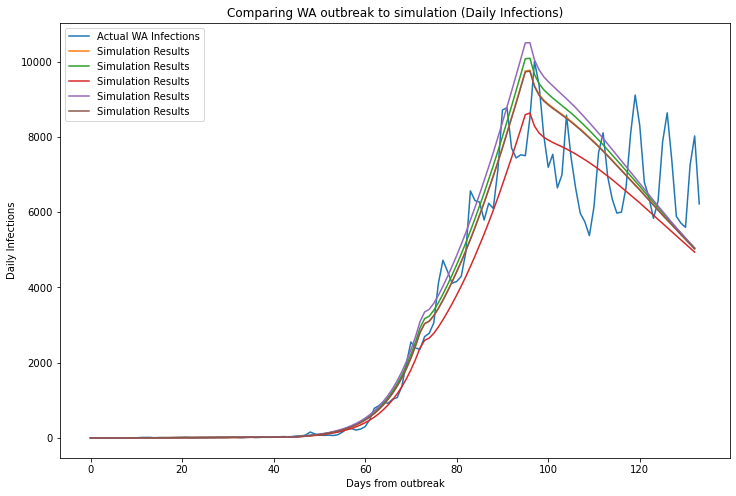

In [25]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
for i in range(num_iter):
    day_infs = allsims_infs[i]
    new_infs = [day_infs[i]-day_infs[i-1] for i in range(1,len(day_infs))]
    plt.plot(new_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


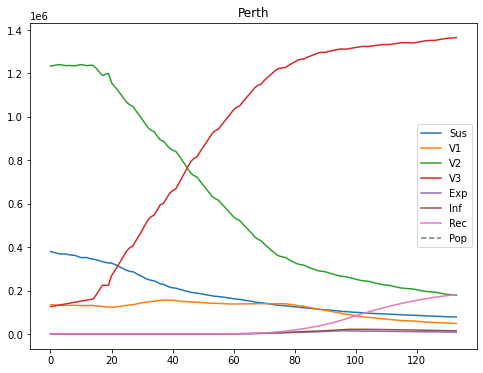

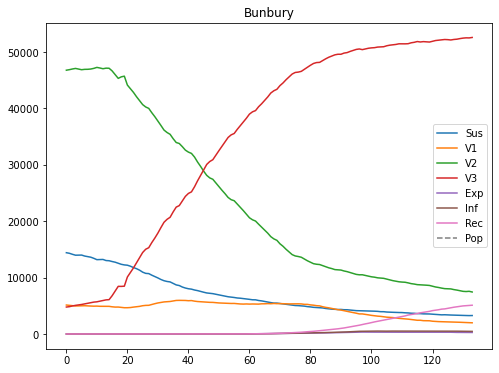

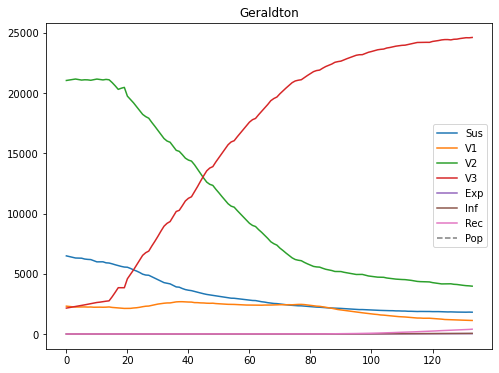

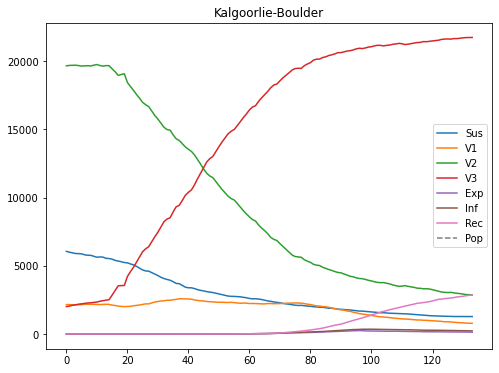

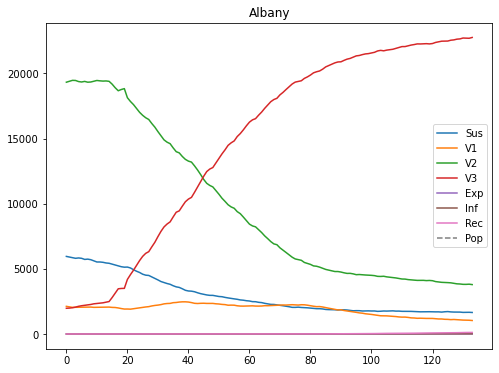

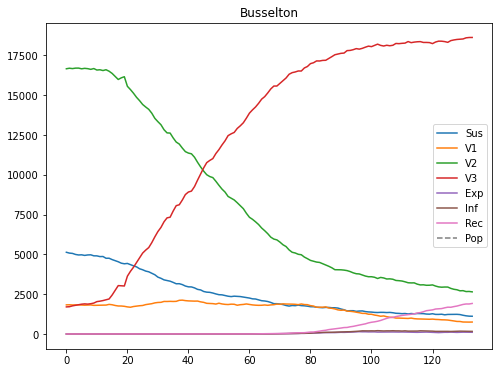

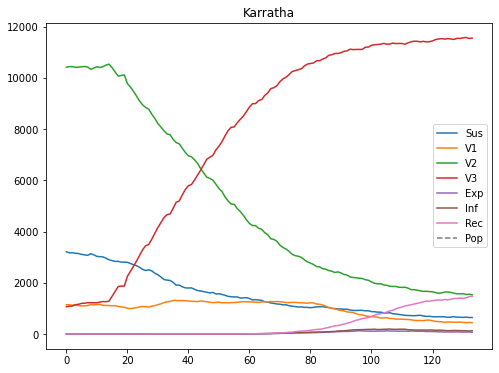

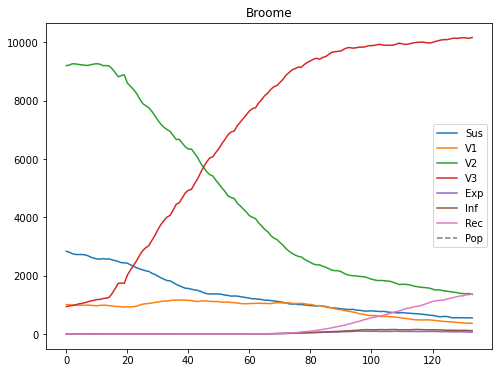

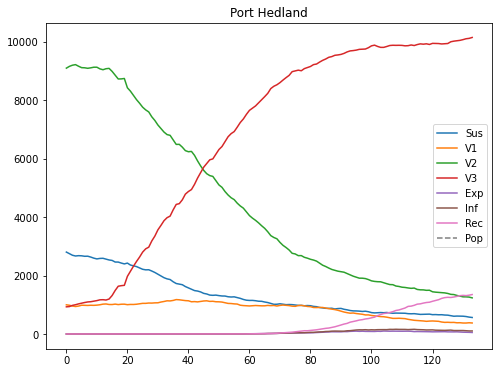

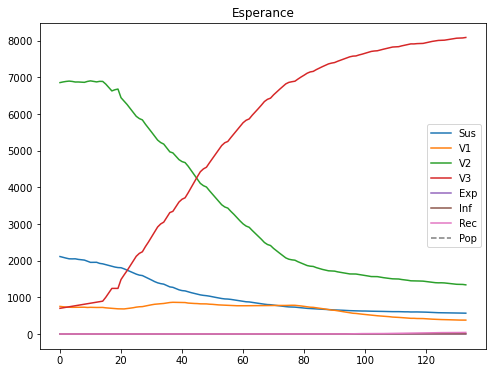

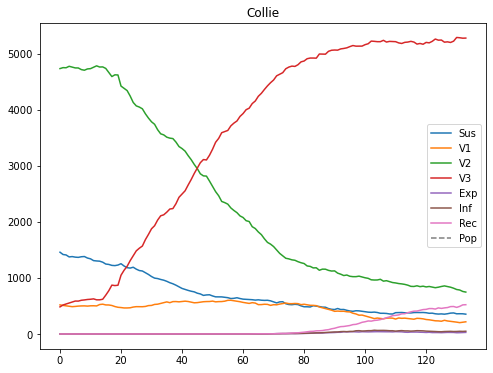

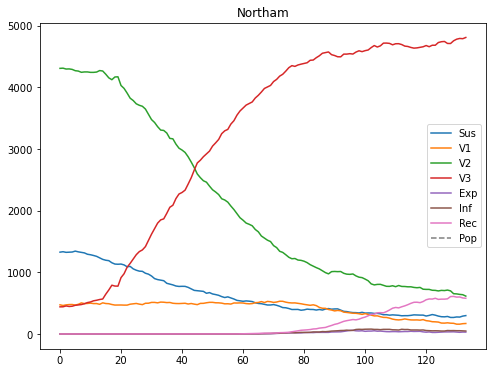

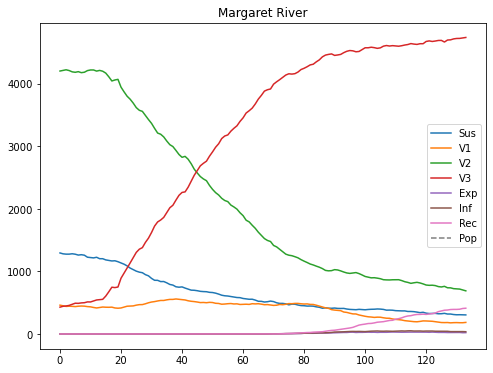

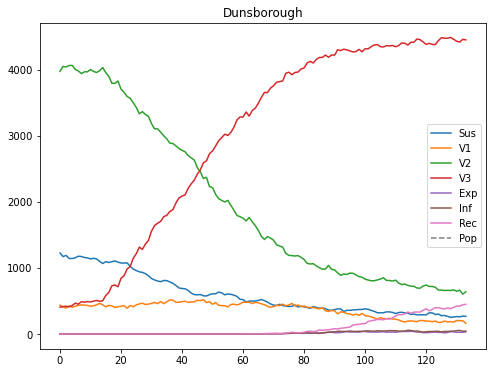

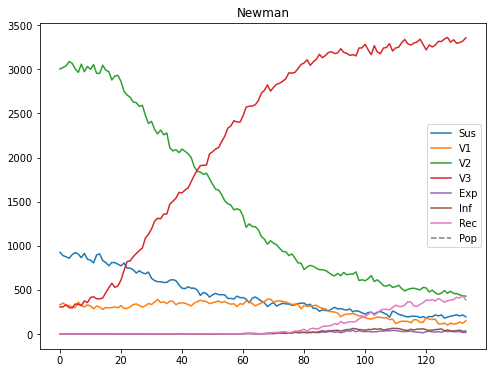

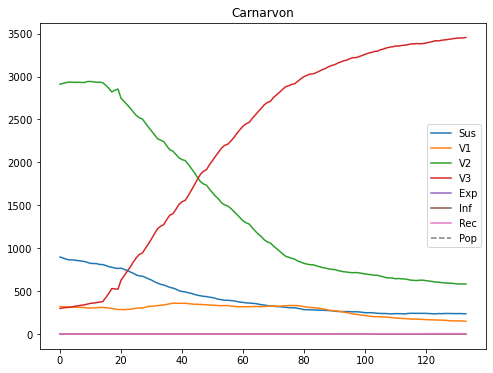

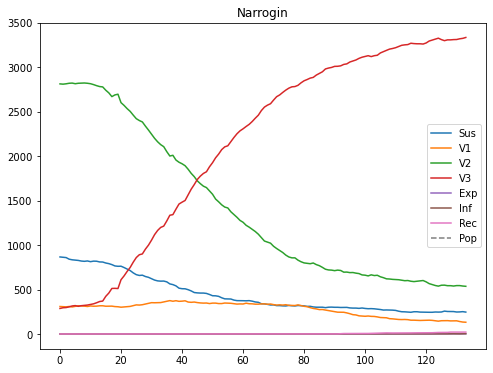

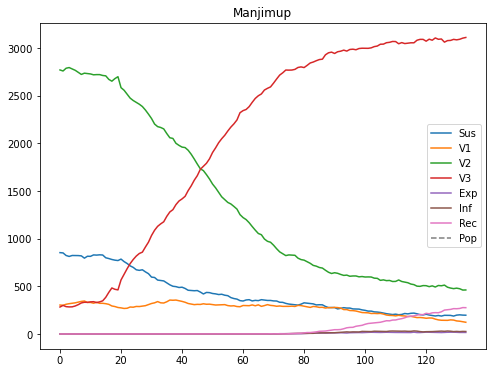

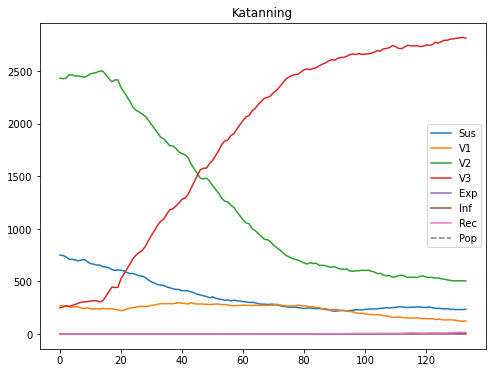

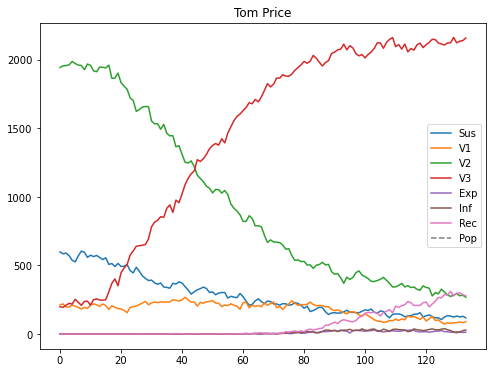

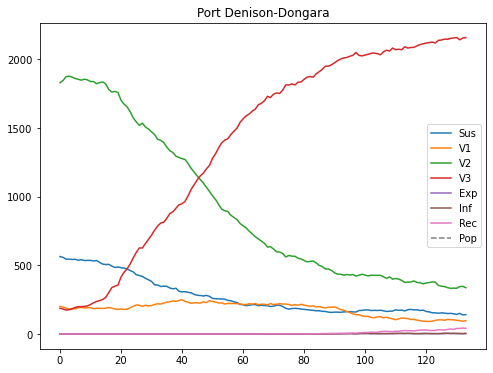

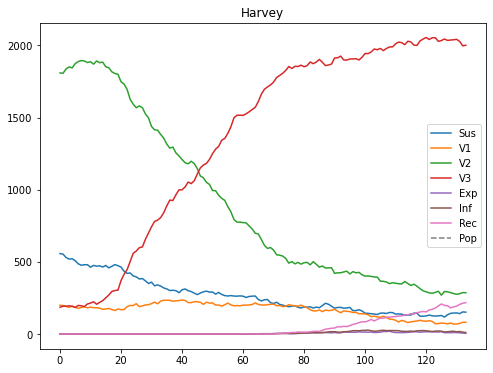

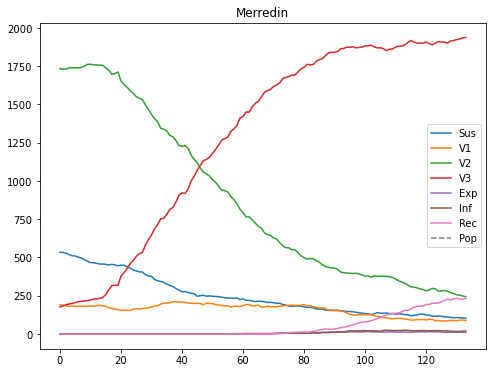

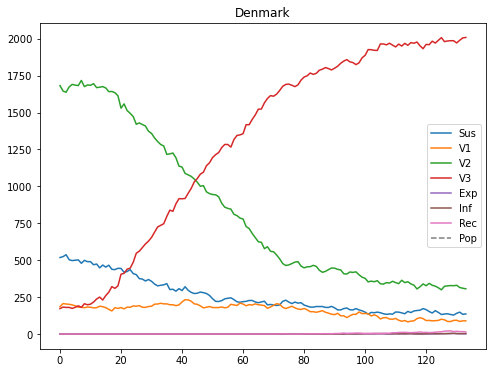

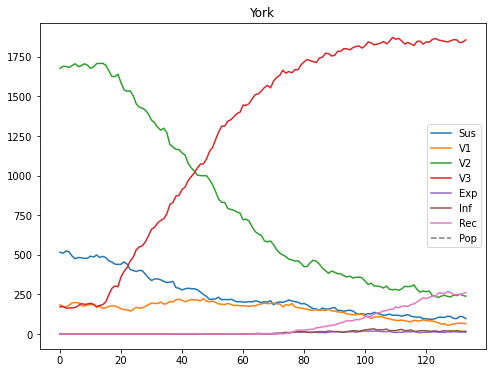

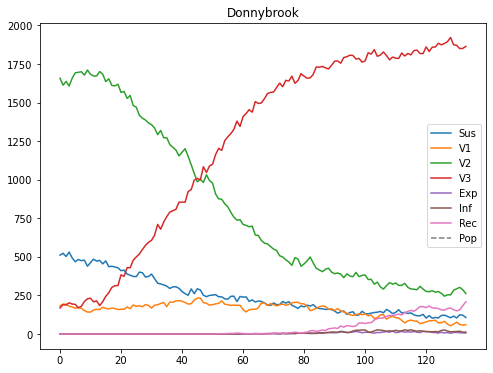

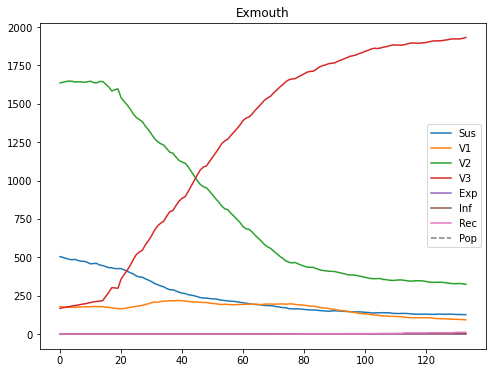

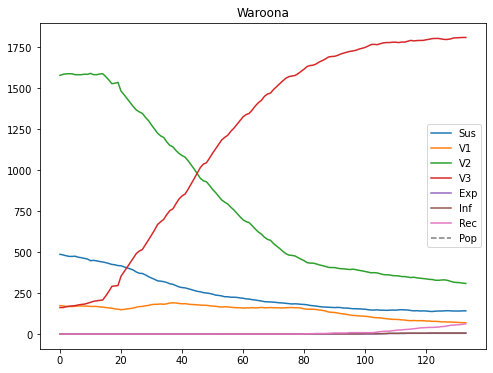

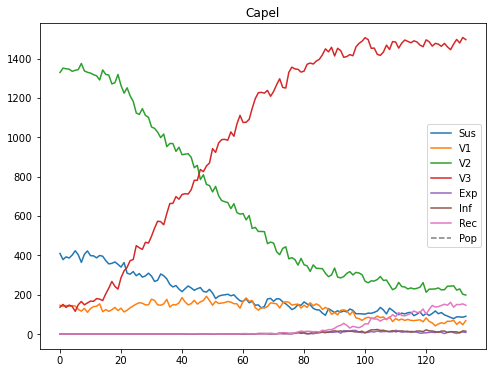

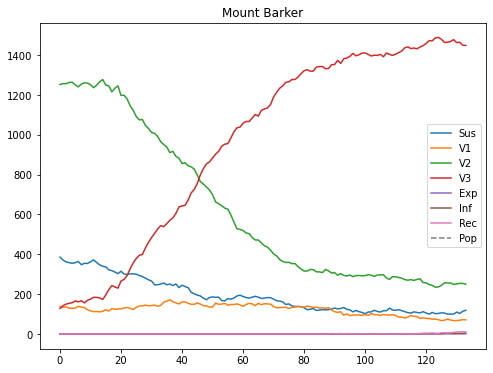

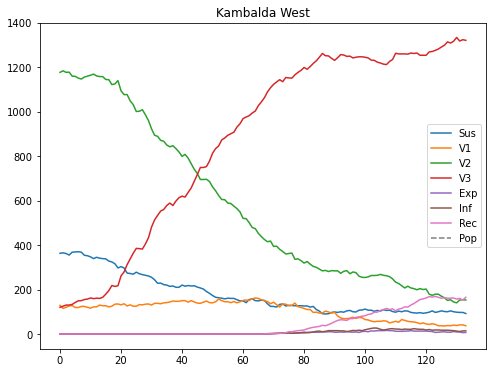

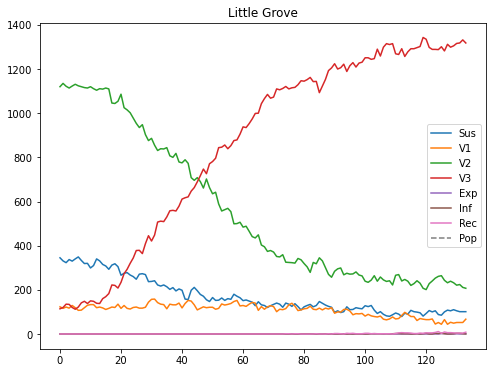

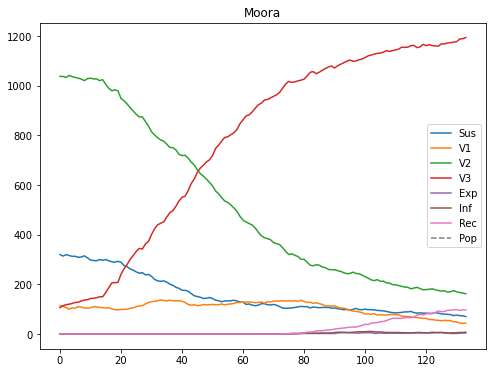

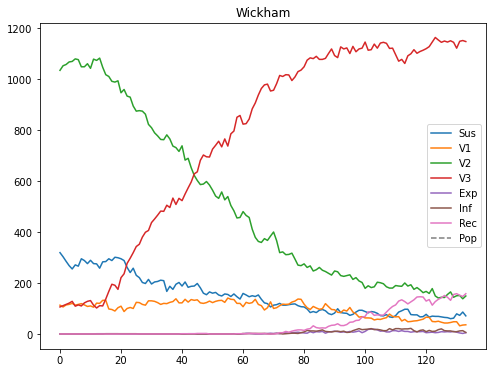

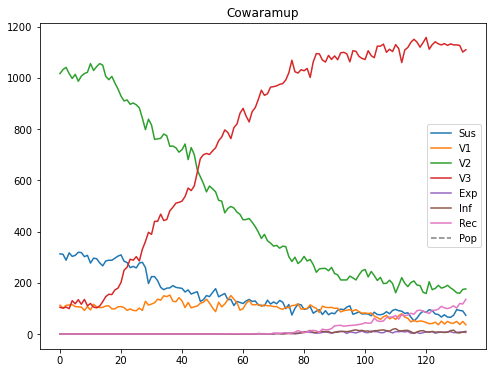

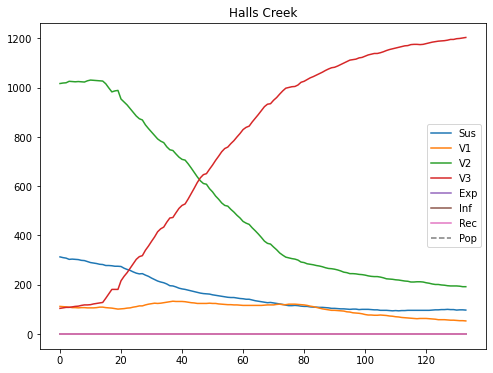

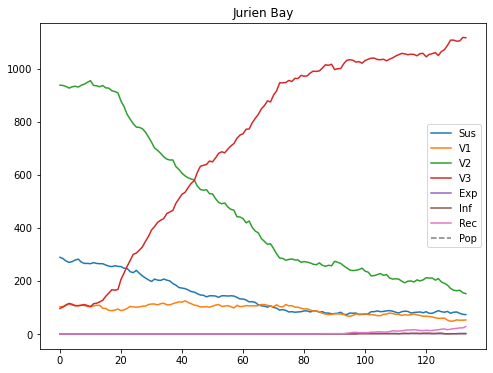

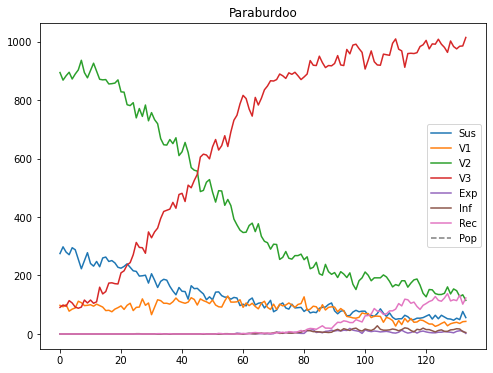

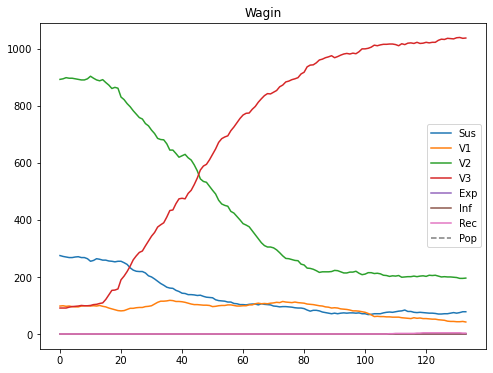

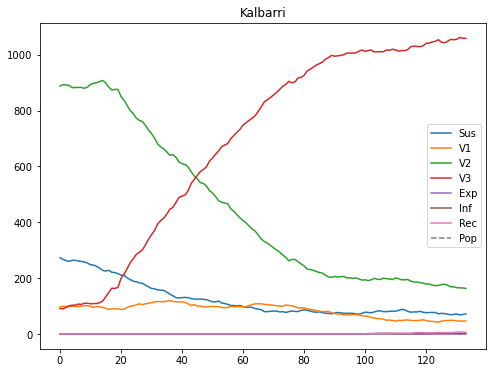

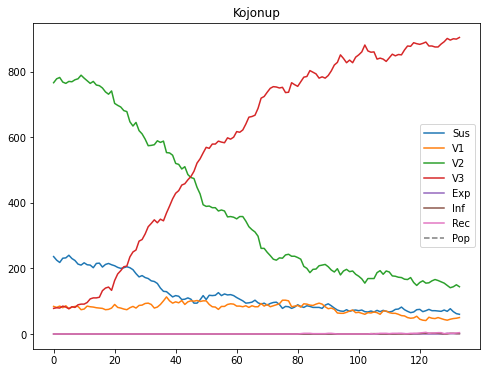

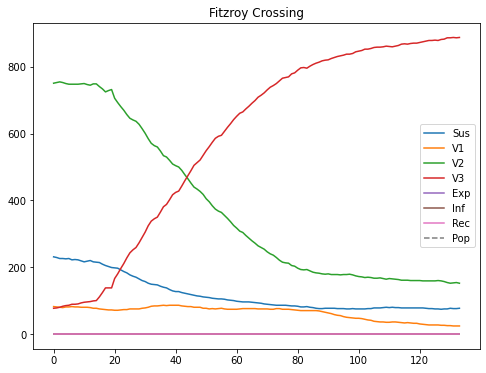

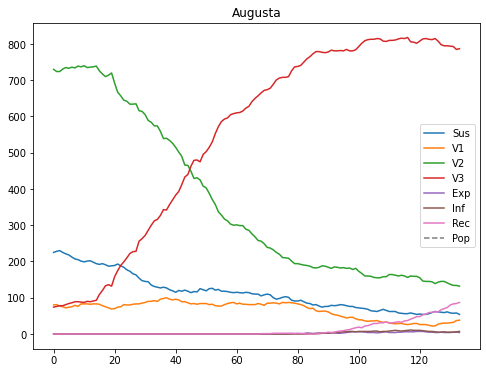

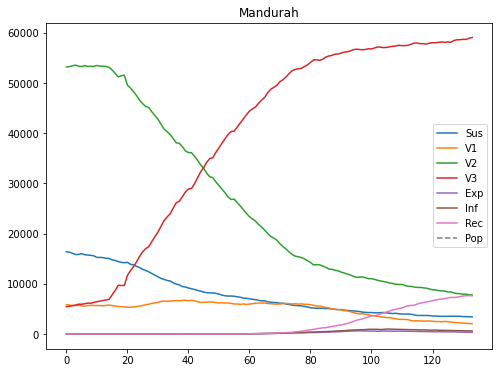

In [61]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
        #if k == 5:
            llist = []
            for day in range(len(model)):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        #else:
        #    for day in range(days):
        #        total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()

In [52]:
#Check for negatives
for model in allsims:
    for i in range(len(model)):
        for j in range(len(model[0])):
            for k in range(len(model[0][0])):
                if model[i][j][k] <0 :
                    print(i,j,k,model[i][j][k])

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


# Scrap Code
Delete when sure the above works.

In [116]:
params = [a1, 1/L, 1/D]

cum_breaks = []
for it in range(1):
    start = time.time()
    model = [town_init]

    x_init = town_init

    day_infs = [0]

    for day in range(days):
        print(it, day)

        if day < 25:
            params[0] = a1
        elif (day>= 25) and (day <75):
            params[0] = a2
        elif day >=75:
            params[0] = a3
        
        if day < 112:
            changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        else:
            changes = [0,0,0]

        dyn, town_infs = dynamics(model[-1], num, steps, params, popn, changes)

        day_infs.append(sum(town_infs) + day_infs[-1])

        inc, out = movement(dyn, day, num, popn)

        dynmov = []
        for i in range(num):
             dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

        model.append(dynmov)
    end = time.time()
    
    breaks = []
    for k in range(num):
        town_cases = []
        for day in range(days):
            town_cases.append(model[day][k][5])
        zeroes = np.nonzero(town_cases)[0]
        if len(zeroes) > 0:
            breaks.append(zeroes[0])
        else:
            breaks.append('NA')
    
    cum_breaks.append(breaks)
    
    print(end-start)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
3156.9202523231506


In [63]:
breaks = []
for k in range(num):
    town_cases = []
    for day in range(days):
        town_cases.append(model[day][k][5])
    zeroes = np.nonzero(town_cases)[0]
    if len(zeroes) > 0:
        breaks.append(zeroes[0])
    else:
        breaks.append(0)
len(breaks)

48

In [64]:
breaks

[0,
 17,
 19,
 10,
 0,
 20,
 11,
 8,
 9,
 0,
 22,
 13,
 46,
 26,
 17,
 0,
 0,
 49,
 33,
 49,
 0,
 13,
 27,
 26,
 25,
 0,
 11,
 25,
 104,
 76,
 22,
 0,
 20,
 0,
 30,
 14,
 29,
 0,
 24,
 15,
 53,
 0,
 52,
 0,
 0,
 97,
 6,
 0]

In [99]:
import cProfile

In [100]:
model = [town_init]

x_init = town_init

day_infs = [0]
cProfile.run('run_the_sim(days, params, a1, a2, a3, a4, uptakes, num, steps, popn, model, day_infs)')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
         7887679 function calls (7882579 primitive calls) in 214.199 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      660    2.009    0.003  213.535    0.324 2771789692.py:1(bernoulli)
     1365    0.003    0.000    0.027    0.000 2920796086.py:1(rounding)
       14    0.000    0.000    0.000    0.000 2920796086.py:11(<listcomp>)
       29    0.000    0.000    0.000    0.000 2920796086.py:18(<listcomp>)
     1365    0.005    0.000    0.010    0.000 2920796086.py:24(<listcomp>)
     1365    0.005    0.000    0.011    0.000 2920796086.py:7(<listcomp>)
        1    0.003    0.003  214.199  214.199 3078943052.py:1(run_the_sim)
      660    0.001    0.000    0.001    0.000 3078943052.py:27(<listcomp>)
     6600    0.025    0.000    0.031    0.000 3207754165.py:1(sveir)
       15    0.014    0.001    0.072    0.005 3798661787.py:1(dynamics)
      660    0.000    0.000    0.000    0.000 3798

    29040    0.047    0.000    0.047    0.000 {built-in method _collections._count_elements}
       15    0.000    0.000    0.000    0.000 {built-in method _operator.mul}
       15    0.000    0.000    0.000    0.000 {built-in method _operator.truediv}
4050/3390    0.002    0.000    0.010    0.000 {built-in method builtins.all}
     1395    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
        1    0.000    0.000  214.199  214.199 {built-in method builtins.exec}
    21030    0.004    0.000    0.008    0.000 {built-in method builtins.getattr}
     5850    0.002    0.000    0.005    0.000 {built-in method builtins.hasattr}
     6015    0.001    0.000    0.001    0.000 {built-in method builtins.hash}
      675    0.000    0.000    0.000    0.000 {built-in method builtins.id}
    89280    0.025    0.000    0.046    0.000 {built-in method builtins.isinstance}
     7005    0.001    0.000    0.001    0.000 {built-in method builtins.issubclass}
1180642/1176232    0.113  

In [9]:
# def bernoulli(flow_list,x,pop,total_out,num):
    
#     p1 = x[0]/pop 
#     p2 = x[1]/pop
#     p3 = x[2]/pop
#     p4 = x[3]/pop
#     p5 = x[4]/pop
#     p6 = x[5]/pop
#     p7 = x[6]/pop

#     vector = []
#     while len(vector) < total_out:
#         r1 = random.rand()
#         if (r1 <= p1) & (vector.count(0) < x[0]):
#             vector.append(0)
#         elif (r1>p1) & (r1 <= (p1+p2)) & (vector.count(1) < x[1]):
#             vector.append(1)
#         elif (r1 > p1+p2) & (r1 <= p1+p2+p3)& (vector.count(2) < x[2]):
#             vector.append(2)
#         elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4) & (vector.count(3) < x[3]):
#             vector.append(3)
#         elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5) & (vector.count(4) < x[4]):
#             vector.append(4)
#         elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6) & (vector.count(5) < x[5]):
#             vector.append(5)
#         elif (r1 > p1+p2+p3+p4+p5+p6) & (vector.count(6) < x[6]):
#             vector.append(6)
#     else: # Complement
#         vector = [0]*x[0]+[1]*x[1]+[2]*x[2]+[3]*x[3]+[4]*x[4]+[5]*x[5]+[6]*x[6]
#         pc1 = 1-p1
#         pc2 = 1-p2
#         pc3 = 1-p3
#         pc4 = 1-p4
#         pc5 = 1-p5
#         pc6 = 1-p6
#         pc7 = 1-p7
#         while len(vector) > total_out:
#             r1 = random.rand()*6
#             if (r1 <= pc1) & (vector.count(0) > 0):
#                 vector.remove(0)
#             elif (r1>pc1) & (r1 <= (pc1+pc2)) & (vector.count(1) > 0):
#                 vector.remove(1)
#             elif (r1 > pc1+pc2) & (r1 <= pc1+pc2+pc3)& (vector.count(2) > 0 ):
#                 vector.remove(2)
#             elif (r1 > pc1+pc2+pc3) & (r1 <= pc1+pc2+pc3+pc4) & (vector.count(3) > 0):
#                 vector.remove(3)
#             elif (r1 > pc1+pc2+pc3+pc4) & (r1 <= pc1+pc2+pc3+pc4+pc5) & (vector.count(4) > 0 ):
#                 vector.remove(4)
#             elif (r1 > pc1+pc2+pc3+pc4+pc5) & (r1 <= pc1+pc2+pc3+pc4+pc5+pc6) & (vector.count(5) > 0):
#                 vector.remove(5)
#             elif (r1 > pc1+pc2+pc3+pc4+pc5+pc6) & (vector.count(6) > 0):
#                 vector.remove(6)
           
    
#     random.shuffle(vector)
    
#     flow_list = rounding(flow_list)
#     cum_flow = [0]
#     for f in flow_list:
#         cum_flow.append(f+cum_flow[-1])
    
#     mo = []
#     for j in range(1,num+1):
#         vec = vector[cum_flow[j-1]:cum_flow[j]]

#         occ = dict(collections.Counter(vec))
#         for i in range(7):
#             occ[i] = occ.get(i,0)
#         mo.append(occ)

#     return mo